In [1]:
from train import MCTS_HYPERPARAMETERS, load_from_checkpoint, collect_episode, train, rotate_training_examples
import torch
from model_3d import MonteCarlo3d
from utils import input_to_tensor_3d
import torch.multiprocessing as mp
from train import save_checkpoint, load_from_checkpoint, ReplayMemory, MetricsHistory
import IPython.display as display
import matplotlib.pyplot as plt

In [2]:
MODEL_TO_LOAD = "" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True

# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hyperparameters = MCTS_HYPERPARAMETERS() # use kwargs to specify non-default values
torch.set_num_threads(15)

In [3]:
if MODEL_TO_LOAD:
    _, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, MonteCarlo3d, load_replay_memory=LOAD_REPLAY_MEMORY)
else:
    model = MonteCarlo3d()
    replay_memory = ReplayMemory(hyperparameters.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay)
    metrics_history = MetricsHistory()
    run_tag = 'no_prepopulate'     
    episode = 0
    hyperparameters.replay_memory_size = 480000
    hyperparameters.minibatch_size = 2048
    hyperparameters.weight_decay = 0.001   
    hyperparameters.num_mcts_train_evals = 10
    hyperparameters.num_episodes = 10

NUM_PROCS = 4

In [4]:
hyperparameters

MCTS_HYPERPARAMETERS(lr=0.0005, weight_decay=0.001, minibatch_size=2048, replay_memory_size=480000, num_mcts_train_evals=10, num_mcts_test_evals=1000, num_episodes=100, checkpoint_every=100, mcts_c_puct=12, mcts_tau=1.0)

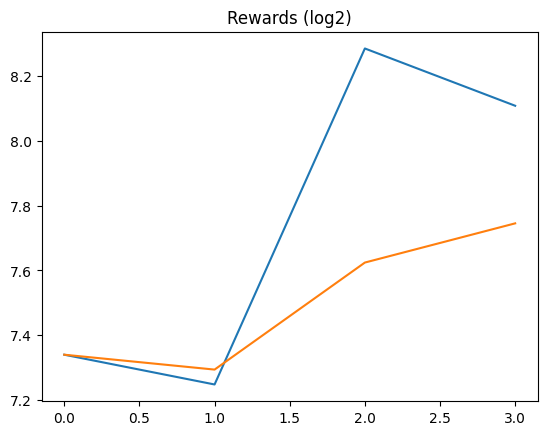

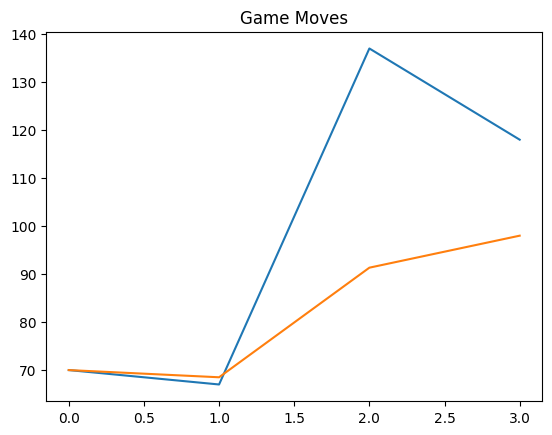

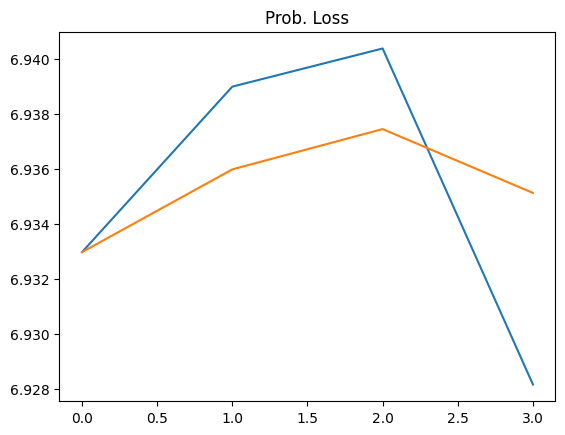

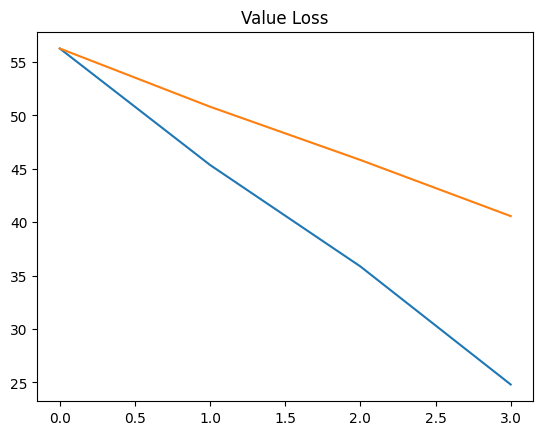

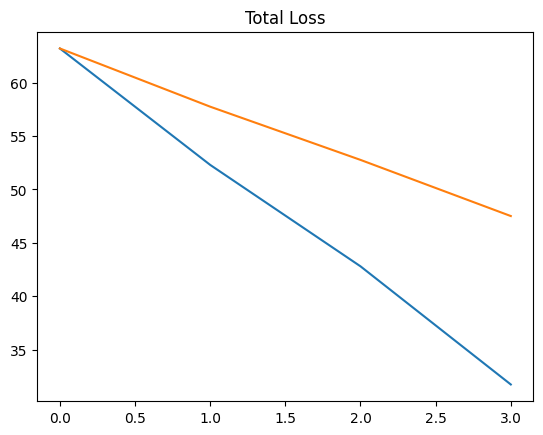

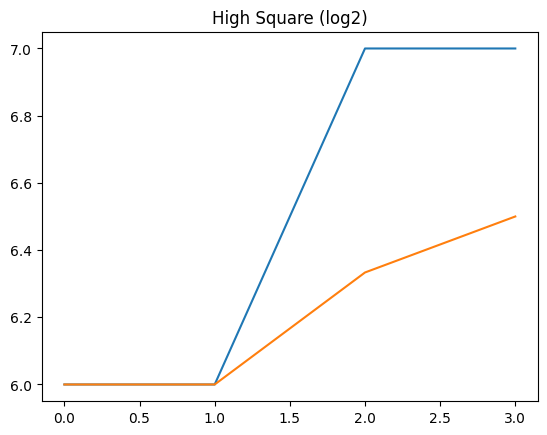

done


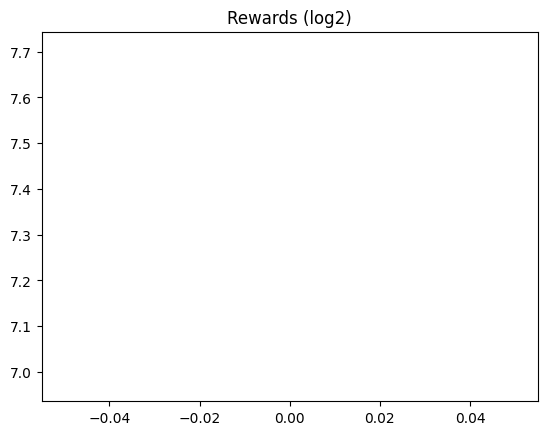

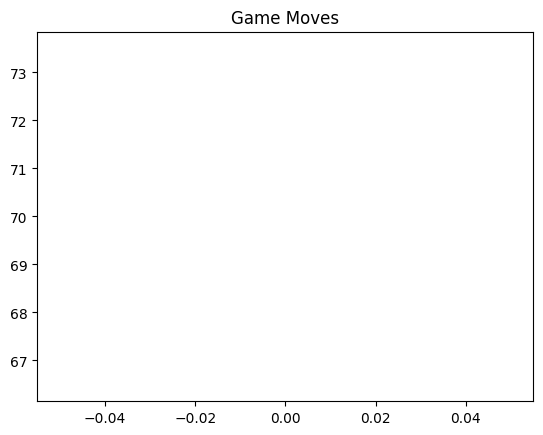

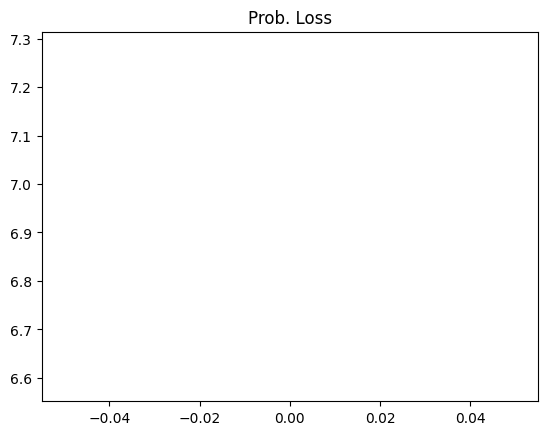

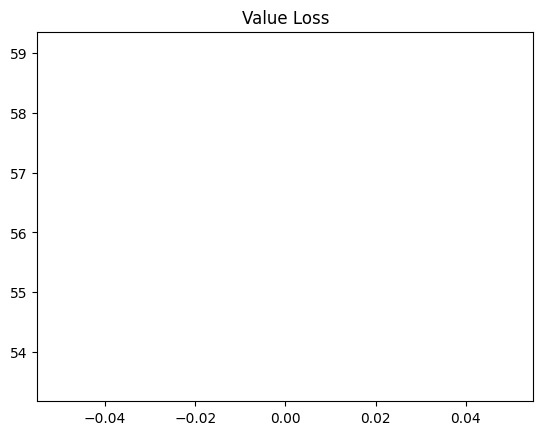

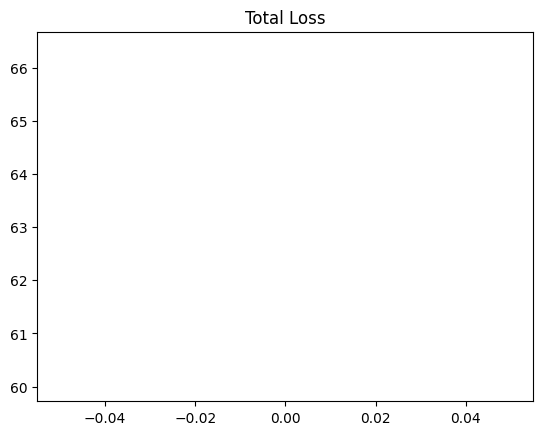

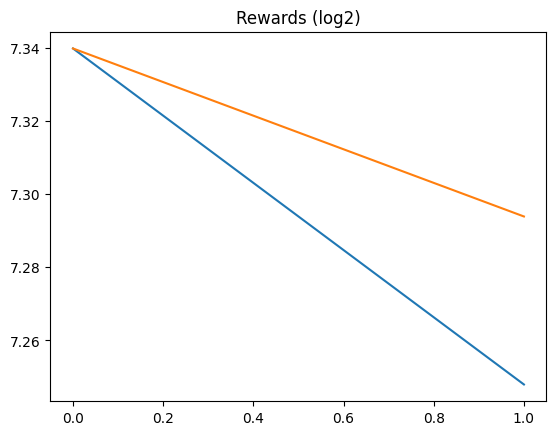

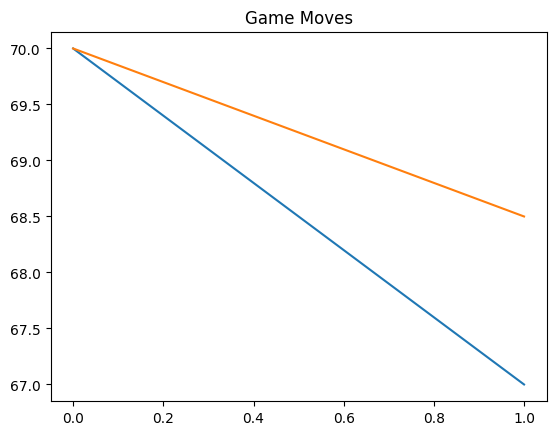

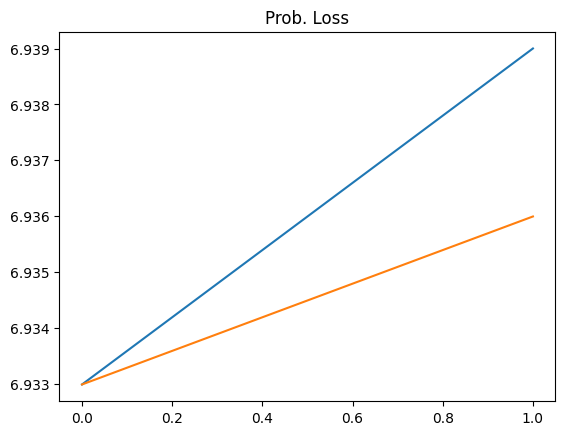

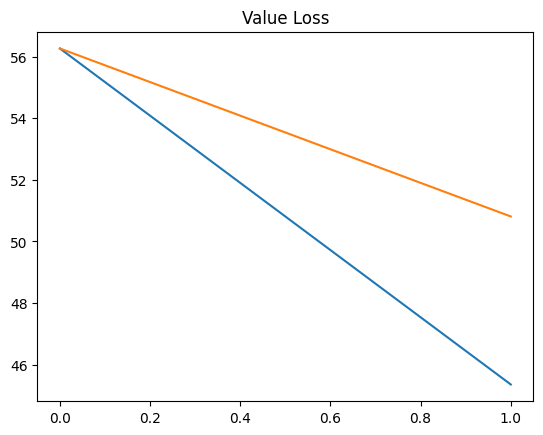

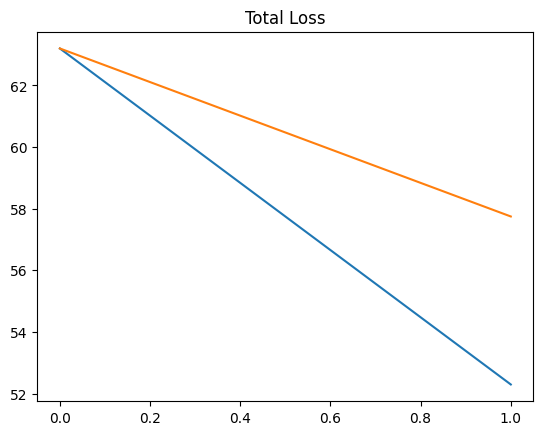

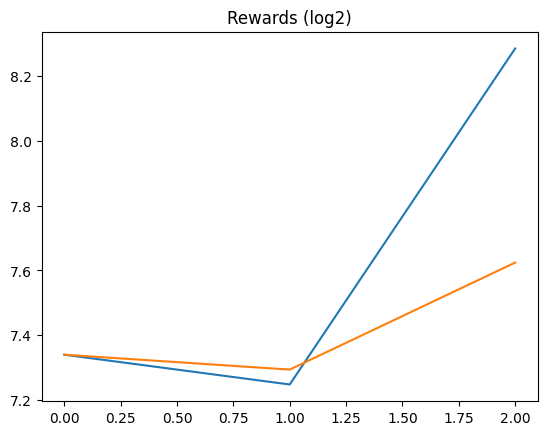

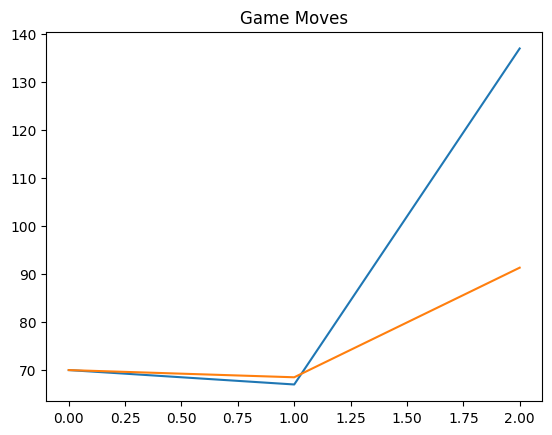

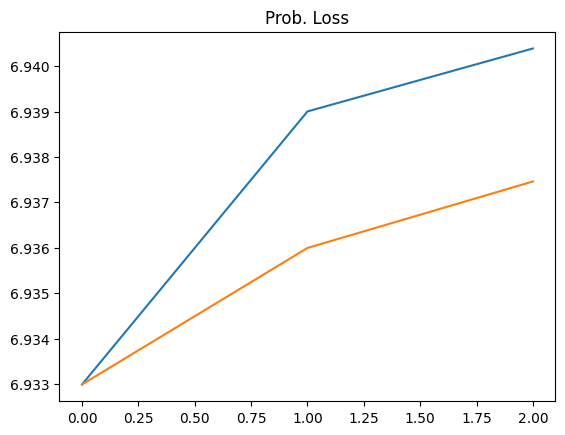

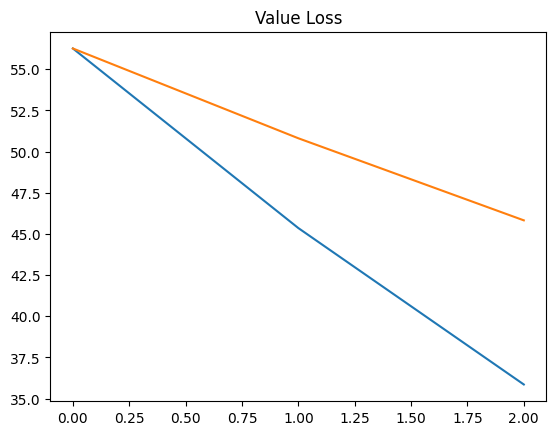

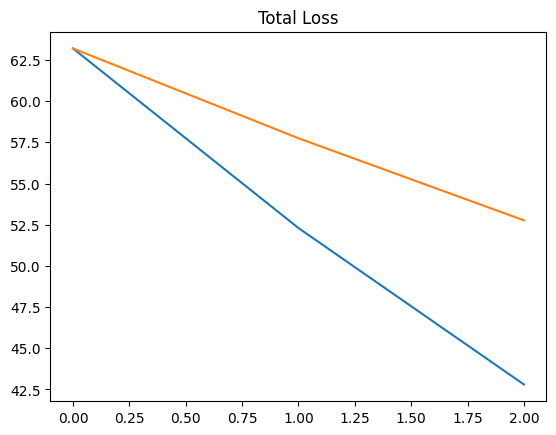

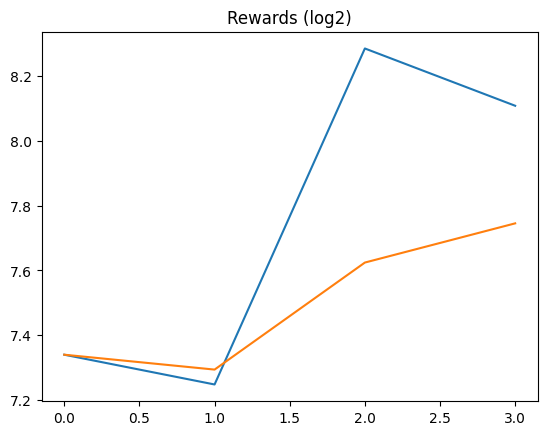

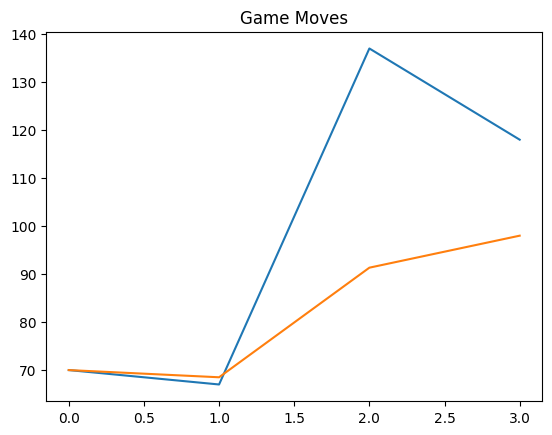

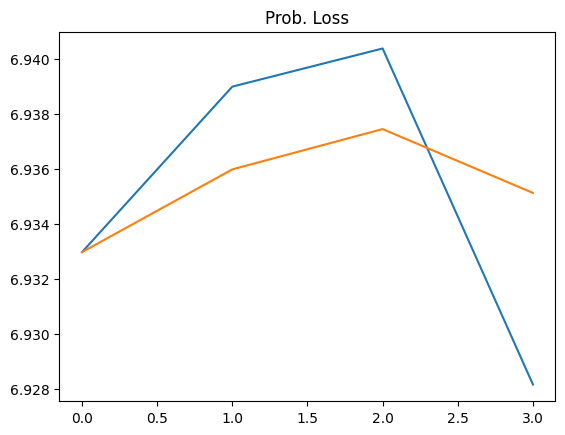

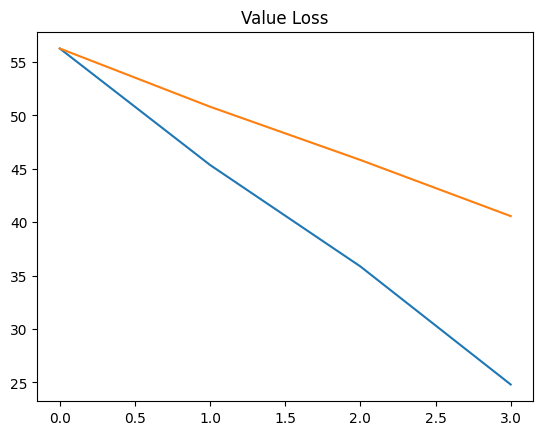

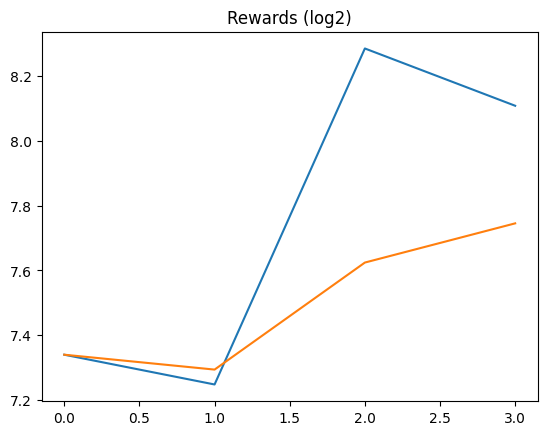

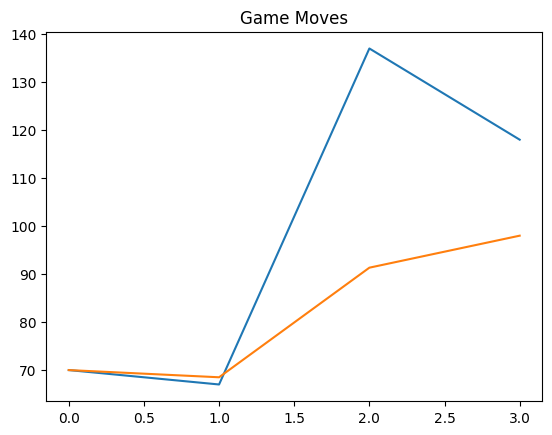

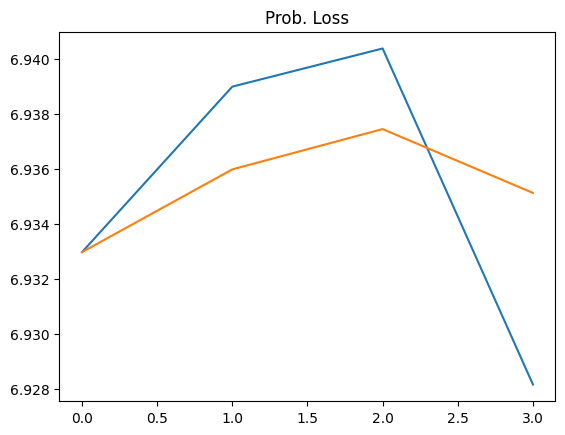

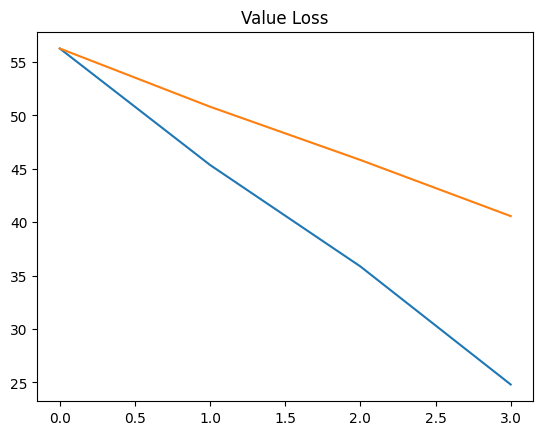

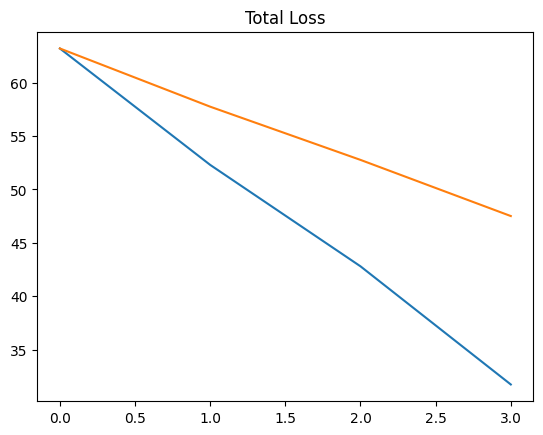

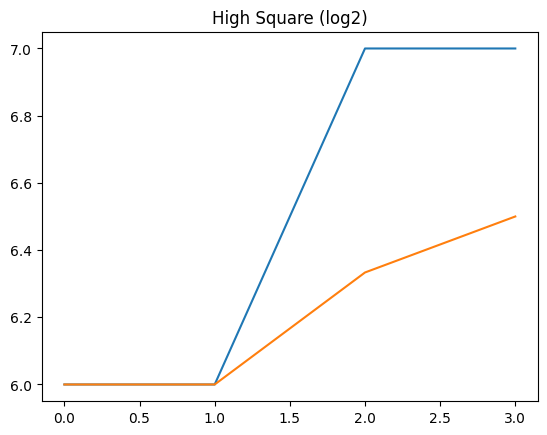

In [4]:
def enque_and_train(results):
    training_examples, reward, moves, high_square, pid = results
    training_examples = rotate_training_examples(training_examples)
    replay_memory.extend(training_examples)
    
    if replay_memory.size() >= hyperparameters.minibatch_size:
        value_loss, prob_loss, total_loss = train(replay_memory.sample(hyperparameters.minibatch_size), model, optimizer, tensor_conversion_fn=input_to_tensor_3d)
        new_best = metrics_history.add_history({
                'reward': reward,
                'game_moves': moves,
                'prob_loss': prob_loss,
                'value_loss': value_loss,
                'total_loss': total_loss,
                'high_square': high_square
            })
        metrics_history.plot_history(window_size=100)
        if new_best:
            print('*** NEW BEST REWARD ***')
        print(f'[EPISODE {metrics_history.episodes}] Total Loss: {total_loss}, Prob Loss {prob_loss}, Value Loss {value_loss}, Reward {reward}, Moves: {moves}, Highest Square: {high_square}, PID: {pid}')
        if metrics_history.episodes % hyperparameters.checkpoint_every == 0:
            print('Saving model checkpoint...')
            save_checkpoint(metrics_history.episodes, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag=run_tag, save_replay_memory=True)
            print('Saved model checkpoint!')
    else:
        print(f'Replay memory size not large enough, {replay_memory.size()} < {hyperparameters.minibatch_size}')
    
    
with mp.Pool(NUM_PROCS) as p:
    results = []
    for n in range(metrics_history.episodes, hyperparameters.num_episodes):
        results.append(p.apply_async(collect_episode, (model, hyperparameters, input_to_tensor_3d, ), callback=enque_and_train, error_callback=print))
    for r in results:
        r.wait()
plt.close()
display.clear_output()
metrics_history.plot_history(window_size=100)
print('done')

In [4]:
from env import _2048Env
from mcts import MCTS_Evaluator
import time

In [5]:

def test():
    model = MonteCarlo3d()
    def to_tensor(data):
        return input_to_tensor_3d(data)

    env = _2048Env()
    env.reset()
    start_time = time.time()
    for _ in range(100):
        env.reset()
        mcts = MCTS_Evaluator(model, env, to_tensor, hyperparameters.mcts_c_puct, hyperparameters.mcts_tau, training=True)
        mcts.choose_progression(50)
    print('Without History', time.time() - start_time)

In [7]:
%prun -s tottime test()

Without History 5.174925088882446
 

         1320545 function calls (1198285 primitive calls) in 5.184 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10082    1.333    0.000    1.333    0.000 {built-in method torch.batch_norm}
    10082    0.965    0.000    0.965    0.000 {built-in method torch.conv3d}
    25205    0.881    0.000    0.881    0.000 {built-in method torch._C._nn.linear}
11259/5000    0.302    0.000    5.050    0.001 mcts.py:47(iterate)
    25205    0.146    0.000    0.146    0.000 {built-in method torch.relu}
100820/5041    0.103    0.000    4.108    0.001 module.py:1188(_call_impl)
     5041    0.092    0.000    4.096    0.001 model_3d.py:26(forward)
     6359    0.079    0.000    0.123    0.000 env.py:119(apply_move)
   196667    0.073    0.000    0.073    0.000 module.py:1256(__getattr__)
    10082    0.059    0.000    0.059    0.000 {method 'add_' of 'torch._C._TensorBase' objects}
    57800    0.058    0.000    0.058    0.000 env.py:1

In [15]:
t

4